# Redis AI Python Client

https://github.com/RedisAI/redisai-py

https://github.com/RedisAI/redisai-py/blob/master/redisai/client.py

In [2]:
import six
import json
import time
from redisai.client import Client, Type, DType, Tensor, BlobTensor
from skimage import io
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Setup RedisAI Client
`redis-master:6379` => Internal Kubernetes DNS host:port

In [3]:
rai = Client(host="redis-master", port=6379)

In [4]:
inputs_np = np.array([1.0, 2.0, 3.0])

vector_np_tensor = Tensor(DType.double, 
                          inputs_np.shape, 
                          inputs_np.tolist())

rai.tensorset("vector_np", vector_np_tensor)

b'OK'

In [5]:
rai.tensorget("vector_np")

<Tensor(shape=[1, 3] type=DOUBLE) at 0x7f0900d3ea58>

In [6]:
rai.tensorget("vector_np").value

[b'1', b'2', b'3']

In [7]:
inputs_np = np.array([1.0, 2.0, 3.0])

np_blob_tensor = BlobTensor.from_numpy(inputs_np)

rai.tensorset("np_blob", np_blob_tensor)

b'OK'

In [8]:
rai.tensorget("np_blob")

<Tensor(shape=[1, 3] type=DOUBLE) at 0x7f0900d3eac8>

In [9]:
rai.tensorget("np_blob").value

[b'1', b'2', b'3']

# Setup ImageNet Dataset (Predictions)
[ImageNet Dataset](http://www.image-net.org/)

`imagenet_classes.json`

In [10]:
prediction_classes = json.load(open("imagenet_classes.json"))

# Load Redis with Trained ResNet50 Model (TensorFlow)
![](https://cdn-images-1.medium.com/max/1600/1*aq0q7gCvuNUqnMHh4cpnIw.png)

In [11]:
!wget -O resnet50.pb https://github.com/RedisAI/redisai-examples/raw/master/models/imagenet/tensorflow/resnet50.pb

--2019-04-02 14:46:00--  https://github.com/RedisAI/redisai-examples/raw/master/models/imagenet/tensorflow/resnet50.pb
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/RedisAI/redisai-examples/master/models/imagenet/tensorflow/resnet50.pb [following]
--2019-04-02 14:46:00--  https://media.githubusercontent.com/media/RedisAI/redisai-examples/master/models/imagenet/tensorflow/resnet50.pb
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.52.133
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102621616 (98M) [application/octet-stream]
Saving to: ‘resnet50.pb’

resnet50.pb         100%[===================>]  97.87M   156MB/s    in 0.6s    

2019-04-02 14:46:03 (

In [12]:
tf_model_path = 'resnet50.pb'
with open(tf_model_path, 'rb') as f:
    tf_model = f.read()

rai.execute_command('AI.MODELSET', 'imagenet_model', 'TF', 'CPU', 'INPUTS', 'images', 'OUTPUTS', 'output', tf_model)

b'OK'

# Load Redis with Image Processing Utils
`data_processing_script.py`

In [13]:
script_path = 'data_processing_script.py'
with open(script_path, 'rb') as f:
    script = f.read()
    
rai.execute_command('AI.SCRIPTSET', 'imagenet_script', 'CPU', script)

b'OK'

# Make Predictions Directly in Redis!

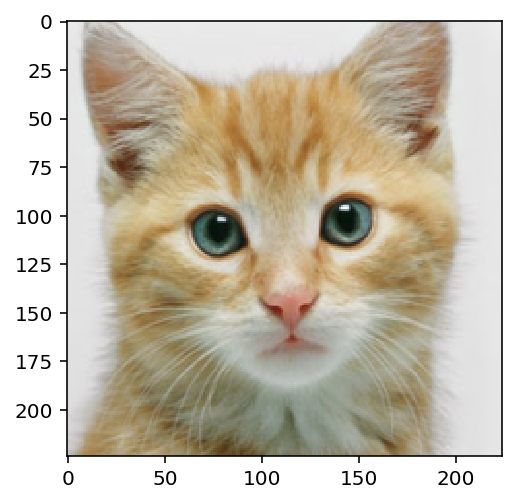

In [14]:
cat_img_path = 'cat.jpg'

cat_image = io.imread(cat_img_path)

cat_image_blob_tensor = BlobTensor(DType.uint8,
                                   cat_image.shape,
                                   cat_image.tobytes())

rai.tensorset("cat_image_blob", cat_image_blob_tensor)

plt.imshow(cat_image)

In [15]:
rai.tensorget("cat_image_blob")

<Tensor(shape=[1, 224, 224, 3] type=INT8) at 0x7f08e8b5dfd0>

In [16]:
rai.tensorget("cat_image_blob").value[100:110]

[234, 238, 235, 235, 235, 235, 235, 235, 235, 235]

In [17]:
start_time = time.time()

rai.execute_command('AI.TENSORSET', 'image', 'UINT8', *cat_image.shape, 'BLOB', cat_image.tobytes())
rai.execute_command('AI.SCRIPTRUN', 'imagenet_script', 'pre_process_3ch', 'INPUTS', 'image', 'OUTPUTS', 'temp1')
rai.execute_command('AI.MODELRUN', 'imagenet_model', 'INPUTS', 'temp1', 'OUTPUTS', 'temp2')
rai.execute_command('AI.SCRIPTRUN', 'imagenet_script', 'post_process', 'INPUTS', 'temp2', 'OUTPUTS', 'out')

end_time = time.time()

prediction = rai.execute_command('AI.TENSORGET', 'out', 'VALUES')

print("Predicted index", prediction[2][0], "in", (end_time - start_time), "seconds")

Predicted index 281 in 1.2468411922454834 seconds


In [18]:
idx = prediction[2][0]

print(idx, "=>", prediction_classes[str(idx)])

281 => tabby, tabby cat


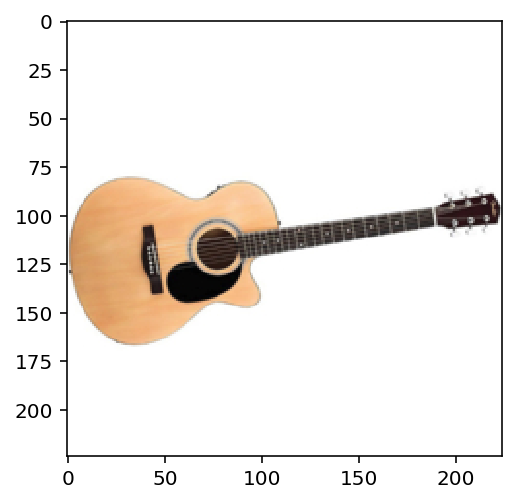

In [19]:
guitar_img_path = 'guitar.jpg'

guitar_image = io.imread(guitar_img_path)

guitar_image_blob_tensor = BlobTensor(DType.uint8,
                                      guitar_image.shape,
                                      guitar_image.tobytes())

rai.tensorset("guitar_image_blob", guitar_image_blob_tensor)

plt.imshow(guitar_image)

In [20]:
rai.tensorget("guitar_image_blob")

<Tensor(shape=[1, 224, 224, 3] type=INT8) at 0x7f08e9ba9b00>

In [21]:
rai.tensorget("guitar_image_blob").value[400:410]

[255, 255, 255, 255, 255, 255, 255, 255, 255, 255]

In [22]:
start_time = time.time()

rai.execute_command('AI.TENSORSET', 'image', 'UINT8', *guitar_image.shape, 'BLOB', guitar_image.tobytes())
rai.execute_command('AI.SCRIPTRUN', 'imagenet_script', 'pre_process_3ch', 'INPUTS', 'image', 'OUTPUTS', 'temp1')
rai.execute_command('AI.MODELRUN', 'imagenet_model', 'INPUTS', 'temp1', 'OUTPUTS', 'temp2')
rai.execute_command('AI.SCRIPTRUN', 'imagenet_script', 'post_process', 'INPUTS', 'temp2', 'OUTPUTS', 'out')

end_time = time.time()

prediction = rai.execute_command('AI.TENSORGET', 'out', 'VALUES')

print("Predicted index", prediction[2][0], "in", (end_time - start_time), "seconds")

Predicted index 402 in 0.10591650009155273 seconds


In [23]:
idx = prediction[2][0]

print(idx, "=>", prediction_classes[str(idx)])

402 => acoustic guitar


In [24]:
!wget https://redislabs.com/wp-content/uploads/2019/03/salvatore-sanfillipo.jpg

--2019-04-02 14:46:06--  https://redislabs.com/wp-content/uploads/2019/03/salvatore-sanfillipo.jpg
Resolving redislabs.com (redislabs.com)... 23.185.0.3, 2620:12a:8000::3, 2620:12a:8001::3
Connecting to redislabs.com (redislabs.com)|23.185.0.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22352 (22K) [image/jpeg]
Saving to: ‘salvatore-sanfillipo.jpg’

salvatore-sanfillip 100%[===================>]  21.83K  --.-KB/s    in 0.006s  

2019-04-02 14:46:06 (3.39 MB/s) - ‘salvatore-sanfillipo.jpg’ saved [22352/22352]



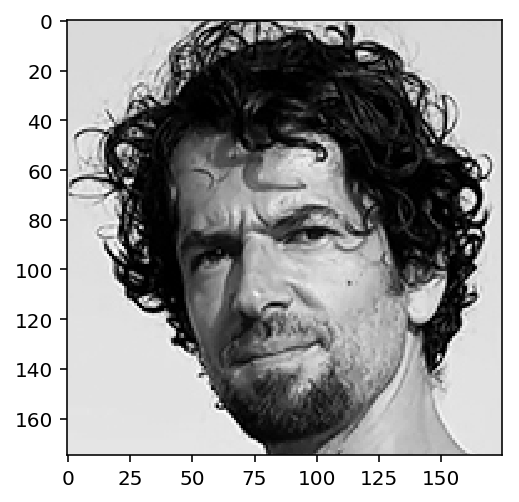

In [25]:
salvatore_img_path = 'salvatore.jpg'

salvatore_image = io.imread(salvatore_img_path)

salvatore_image_blob_tensor = BlobTensor(DType.uint8,
                                         salvatore_image.shape,
                                         salvatore_image.tobytes())

rai.tensorset("salvatore_image_blob", salvatore_image_blob_tensor)

plt.imshow(salvatore_image)

In [26]:
rai.tensorget("salvatore_image_blob")

<Tensor(shape=[1, 175, 175, 3] type=INT8) at 0x7f08e9bbfe80>

In [27]:
rai.tensorget("salvatore_image_blob").value[400:410]

[210, 210, 214, 214, 214, 216, 216, 216, 217, 217]

In [28]:
start_time = time.time()

rai.execute_command('AI.TENSORSET', 'image', 'UINT8', *salvatore_image.shape, 'BLOB', salvatore_image.tobytes())
rai.execute_command('AI.SCRIPTRUN', 'imagenet_script', 'pre_process_3ch', 'INPUTS', 'image', 'OUTPUTS', 'temp1')
rai.execute_command('AI.MODELRUN', 'imagenet_model', 'INPUTS', 'temp1', 'OUTPUTS', 'temp2')
rai.execute_command('AI.SCRIPTRUN', 'imagenet_script', 'post_process', 'INPUTS', 'temp2', 'OUTPUTS', 'out')

end_time = time.time()

prediction = rai.execute_command('AI.TENSORGET', 'out', 'VALUES')

print("Predicted index", prediction[2][0], "in", (end_time - start_time), "seconds")

Predicted index 424 in 0.07444453239440918 seconds


In [29]:
idx = prediction[2][0]

print(idx, "=>", prediction_classes[str(idx)])

424 => barbershop
